In [1]:
from utils_library.cuda import get_cuda

device = get_cuda()
print("\nDevice: ", device)

__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 2080 SUPER
__CUDA Device Total Memory [GB]: 8.58947584
Total memory -> 7.99957275390625 GB
Memory reserved -> 0.0 GB
Memory allocated -> 0.0 GB
Free reserved -> 0.0 GB

Device:  cuda


In [2]:
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import torch.utils.data as data
import torchvision
from torchvision import transforms
from tqdm import tqdm
torch.cuda.is_available()

True

In [3]:
from utils_library.vit import ViT

# Hyperparameters

In [4]:
# Hyperparameters:
batch_size = 64 
num_epochs = 20
lr = 3e-5  # 0.00003
gamma = 0.7
seed = 142


# Model Settings 

img_size=128
num_channels=3
patch_size=32

num_classes=2
num_heads=8
num_transformer_layers=12

embedding_dim=768
dropout=0.1
mlp_size=3072


# Tensor Transforms

In [5]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image tensors
])

In [6]:
train_ds = torchvision.datasets.ImageFolder("data/train", transform=transform)
valid_ds = torchvision.datasets.ImageFolder("data/validation", transform=transform)
test_ds = torchvision.datasets.ImageFolder("data/test", transform=transform)

# Data Loaders

In [7]:
train_dataloader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_dataloader = data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
test_dataloader  = data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

# Model Building

In [8]:
# Vision Transformer Model
model = ViT(
    img_size=img_size,
    num_channels=num_channels, 
    patch_size=patch_size,
    
    embedding_dim=embedding_dim,
    dropout=dropout,
    mlp_size=mlp_size,

    num_transformer_layers=num_transformer_layers,
    num_heads=num_heads,
    num_classes=num_classes
    )

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Learning Rate Scheduler for Optimizer:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [9]:
from torchinfo import summary 
from torchviz import make_dot

summary(model=model,
        input_size=(1, num_channels, img_size, img_size))
# make_dot( params=dict(model.named_parameters()))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 2]                    13,824
├─PatchEmbedding: 1-1                         [1, 16, 768]              --
│    └─Conv2d: 2-1                            [1, 768, 4, 4]            2,360,064
│    └─Flatten: 2-2                           [1, 768, 16]              --
├─Dropout: 1-2                                [1, 17, 768]              --
├─TransformerEncoder: 1-3                     [1, 17, 768]              --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 17, 768]              7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 17, 768]              7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 17, 768]              7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 17, 768]              7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 17, 76

In [10]:
training_loop_results = []


# Training loop
for epoch in range(num_epochs):
    print("Epoch: ", epoch)

    model.train()  # Set model to training mode

    epoch_loss = 0
    epoch_accuracy = 0

    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Zero the gradients
        optimizer.zero_grad()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)


    # Step 6: Evaluation
    model.eval()
    with torch.no_grad():
        
        epoch_val_accuracy = 0
        epoch_val_loss = 0

        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            val_output = model(images)
            val_loss = criterion(val_output, labels)

            acc = (val_output.argmax(dim=1) == labels).float().mean()
            epoch_val_accuracy += acc / len(val_dataloader)
            epoch_val_loss += val_loss / len(val_dataloader)


    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {epoch_loss:.4f}, "
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {epoch_accuracy:.4f}")
    
    training_loop_results.append({"Epoch": epoch+1,"Training Loss": epoch_loss, "Validation Loss": epoch_val_loss, "Validation Accuracy": epoch_accuracy})

    # Define the file path for saving the model
    model_path = f"model_cats_dogs_{epoch+1}.pt"

    # Save the model
    torch.save(model.state_dict(), model_path)


# Evaluation on test set

total_correct = 0
total_samples = 0

model.eval()
with torch.no_grad():
    
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        # val_loss = criterion(outputs, labels)

        # acc = (val_output.argmax(dim=1) == labels).float().mean()
        # epoch_val_accuracy += acc / len(test_dataloader)
        # epoch_val_loss += val_loss / len(test_dataloader)

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy}")

# Step 8: Save and deploy the trained model
torch.save(model.state_dict(), "transformer_model.pth")

Epoch:  0


  0%|          | 0/274 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Epoch [1/20], Training Loss: 0.7174, Validation Loss: 0.6864, Validation Accuracy: 0.5037
Epoch:  1


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Epoch [2/20], Training Loss: 0.6841, Validation Loss: 0.6554, Validation Accuracy: 0.5524
Epoch:  2


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch [3/20], Training Loss: 0.6697, Validation Loss: 0.6430, Validation Accuracy: 0.5939
Epoch:  3


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Epoch [4/20], Training Loss: 0.6548, Validation Loss: 0.6465, Validation Accuracy: 0.6102
Epoch:  4


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Epoch [5/20], Training Loss: 0.6516, Validation Loss: 0.6384, Validation Accuracy: 0.6119
Epoch:  5


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Epoch [6/20], Training Loss: 0.6457, Validation Loss: 0.6382, Validation Accuracy: 0.6208
Epoch:  6


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch [7/20], Training Loss: 0.6361, Validation Loss: 0.6373, Validation Accuracy: 0.6293
Epoch:  7


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch [8/20], Training Loss: 0.6293, Validation Loss: 0.6191, Validation Accuracy: 0.6374
Epoch:  8


100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Epoch [9/20], Training Loss: 0.6136, Validation Loss: 0.6028, Validation Accuracy: 0.6537
Epoch:  9


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Epoch [10/20], Training Loss: 0.5994, Validation Loss: 0.6235, Validation Accuracy: 0.6660
Epoch:  10


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch [11/20], Training Loss: 0.5892, Validation Loss: 0.5759, Validation Accuracy: 0.6757
Epoch:  11


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Epoch [12/20], Training Loss: 0.5781, Validation Loss: 0.5871, Validation Accuracy: 0.6881
Epoch:  12


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Epoch [13/20], Training Loss: 0.5703, Validation Loss: 0.5922, Validation Accuracy: 0.6956
Epoch:  13


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


Epoch [14/20], Training Loss: 0.5569, Validation Loss: 0.5753, Validation Accuracy: 0.7069
Epoch:  14


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


Epoch [15/20], Training Loss: 0.5453, Validation Loss: 0.5837, Validation Accuracy: 0.7172
Epoch:  15


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


Epoch [16/20], Training Loss: 0.5397, Validation Loss: 0.6052, Validation Accuracy: 0.7204
Epoch:  16


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Epoch [17/20], Training Loss: 0.5259, Validation Loss: 0.5792, Validation Accuracy: 0.7315
Epoch:  17


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


Epoch [18/20], Training Loss: 0.5149, Validation Loss: 0.6209, Validation Accuracy: 0.7388
Epoch:  18


100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Epoch [19/20], Training Loss: 0.5019, Validation Loss: 0.5675, Validation Accuracy: 0.7483
Epoch:  19


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


Epoch [20/20], Training Loss: 0.4878, Validation Loss: 0.6081, Validation Accuracy: 0.7606


100%|██████████| 79/79 [00:18<00:00,  4.16it/s]


Test Accuracy: 0.7032


In [23]:
import pandas as pd
import re
def extract_normal_value(tensor):
    return tensor.item()

df = pd.DataFrame(training_loop_results)
df['Training Loss'] = df['Training Loss'].apply(extract_normal_value)
df['Validation Loss'] = df['Validation Loss'].apply(extract_normal_value)
df['Validation Accuracy'] = df['Validation Accuracy'].apply(extract_normal_value)

In [24]:
df

,Epoch,Training Loss,Validation Loss,Validation Accuracy
0,1,0.717410,0.686436,0.503676
1,2,0.684081,0.655351,0.552407
2,3,0.669663,0.643021,0.593860
3,4,0.654755,0.646454,0.610195
4,5,0.651618,0.638449,0.611880
5,6,0.645728,0.638246,0.620824
6,7,0.636125,0.637288,0.629316
7,8,0.629289,0.619121,0.637357
8,9,0.613648,0.602753,0.653728
9,10,0.599367,0.623471,0.665992


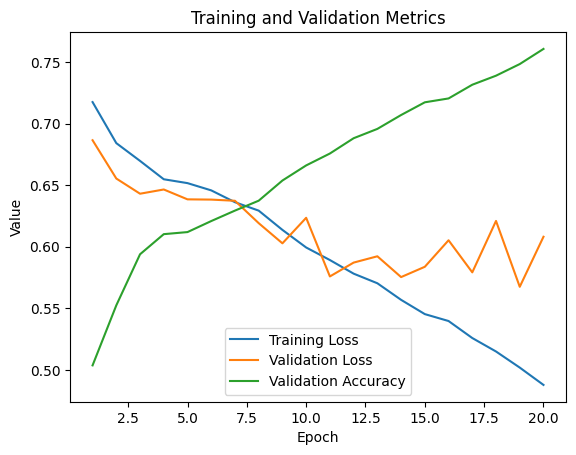

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x='Epoch', y='Training Loss', label='Training Loss')
sns.lineplot(data=df, x='Epoch', y='Validation Loss', label='Validation Loss')
sns.lineplot(data=df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')

plt.savefig('results/training_loop.png')